In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator,load_img
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,Dropout,Flatten,Dense,Activation,BatchNormalization

In [2]:
train_dir = '/content/drive/MyDrive/Colab Notebooks/Projects DL/MoodRecognition/train'
test_dir = '/content/drive/MyDrive/Colab Notebooks/Projects DL/MoodRecognition/test'
val_dir = '/content/drive/MyDrive/Colab Notebooks/Projects DL/MoodRecognition/validation'

categories = os.listdir(train_dir)

### Fetch Training Data

In [3]:
name = []
label = []
for i in range(len(categories)):
  
  filenames=os.listdir(train_dir+"/"+categories[i])
  for f_name in filenames:
    name.append(f_name)
    label.append(categories[i])

df_train = pd.DataFrame({"Path":name , "Category":label})
df_train

,Path,Category
0,Training_89462736.jpg,angry
1,Training_75201127.jpg,angry
2,Training_92321166.jpg,angry
3,Training_63914663.jpg,angry
4,Training_38970819.jpg,angry
...,...,...
28714,Training_62165241.jpg,neutral
28715,Training_30971124.jpg,neutral
28716,Training_28069544.jpg,neutral
28717,Training_48150900.jpg,neutral


In [4]:
df_train.shape
total_train=df_train.shape[0]        # Size of Train (Needed for model.fit_generator)

## Fetch Validation Data


In [5]:
name = []
label = []
for i in range(len(categories)):
  
  filenames=os.listdir(val_dir+"/"+categories[i])
  for f_name in filenames:
    name.append(f_name)
    label.append(categories[i])

df_val = pd.DataFrame({"Path":name , "Category":label})
df_val

,Path,Category
0,PublicTest_26532100.jpg,angry
1,PublicTest_48156348.jpg,angry
2,PublicTest_18770630.jpg,angry
3,PublicTest_47374366.jpg,angry
4,PrivateTest_76880087.jpg,angry
...,...,...
5423,PublicTest_24691289.jpg,neutral
5424,PublicTest_63640849.jpg,neutral
5425,PublicTest_85787847.jpg,neutral
5426,PublicTest_64856942.jpg,neutral


In [6]:
df_val.shape

(5428, 2)

### Fetch Test Data

In [7]:
name = []
label = []
for i in range(len(categories)):
  
  filenames=os.listdir(test_dir+"/"+categories[i])
  for f_name in filenames:
    name.append(f_name)
    label.append(categories[i])

df_test = pd.DataFrame({"Path":name , "Category":label})
df_test

,Path,Category
0,PrivateTest_19777137.jpg,angry
1,PrivateTest_4115089.jpg,angry
2,PrivateTest_50685265.jpg,angry
3,PrivateTest_26910183.jpg,angry
4,PrivateTest_47881235.jpg,angry
...,...,...
1745,PrivateTest_66773819.jpg,neutral
1746,PrivateTest_67534145.jpg,neutral
1747,PrivateTest_68065868.jpg,neutral
1748,PrivateTest_66109599.jpg,neutral


In [8]:
df_test.shape

(1750, 2)

In [9]:
df_test["Category"].value_counts()

fear        300
sad         300
angry       300
happy       300
neutral     300
surprise    200
disgust      50
Name: Category, dtype: int64

## Distribution of Train Data.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


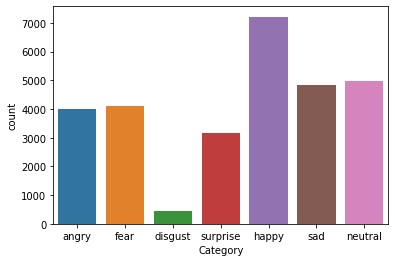

In [10]:
sns.countplot(df_train["Category"])

### Visualize Our Data

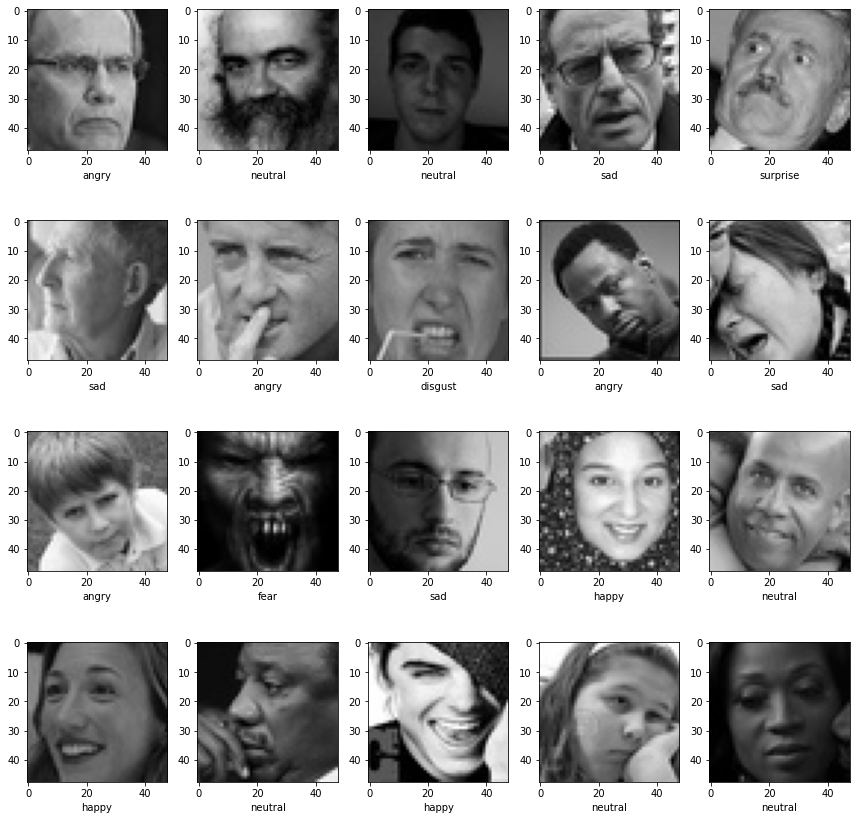

In [11]:
Image_Width=48
Image_Height=48
Image_Size=(Image_Width,Image_Height)
Image_Channels=3

plt.figure(figsize=(12, 12))
j=0

for i in np.random.randint(0,28719 , 20):
  img = load_img(train_dir+"/"+df_train["Category"].iloc[i] +"/"+df_train["Path"].iloc[i], target_size=Image_Size)
  plt.subplot(4, 5, j+1)
  j=j+1
  plt.imshow(img)
  plt.xlabel(df_train["Category"].iloc[i]) # Print Predicted category
plt.tight_layout()
plt.show()


## Create Generators for Train , Validation , Test

In [12]:
train_datagen = ImageDataGenerator(rotation_range=15, 
                                rescale=1./255,
                                shear_range=0.1,
                                zoom_range=0.2,
                                horizontal_flip=True,
                                width_shift_range=0.1,
                                height_shift_range=0.1)

val_datagen = ImageDataGenerator(rotation_range=15, 
                                rescale=1./255,
                                shear_range=0.1,
                                zoom_range=0.2,
                                horizontal_flip=True,
                                width_shift_range=0.1,
                                height_shift_range=0.1 )
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        
        target_size=(128,128),
        batch_size=64,
        color_mode="rgb", ## V.V.V IMP as our original data is grayscale, it wont be accepted by VGG unless converted to RGB
        class_mode="categorical")

validation_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size=(128,128),
        batch_size=64,
        color_mode="rgb",
        class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(128,128),
        batch_size=64,
        color_mode="rgb",
        class_mode='categorical')

Found 28719 images belonging to 7 classes.
Found 5428 images belonging to 7 classes.
Found 1750 images belonging to 7 classes.


### Build CNN Network

In [13]:
# Defining ResNet50 as a Deep Convolutional Neural Network
from keras.applications.resnet50 import ResNet50 #For Transfer Learning

base_model = ResNet50(include_top = False, weights = 'imagenet', input_shape = (128,128,3), classes = 7)
base_model.trainable = False # Setting trainable to false because we want to make sure that this layer isn’t re-trained.

#Adding the final layers to the above base models where the actual classification is done in the dense layers
model= Sequential()
model.add(base_model) 
model.add(Flatten()) 

#Adding the Dense layers along with activation and batch normalization

model.add(BatchNormalization())
model.add(Dense(1024,activation=('relu'))) #,input_dim=512
model.add(Dropout(0.25))

model.add(BatchNormalization())
model.add(Dense(512,activation=('relu'))) 
model.add(Dropout(0.25))

model.add(BatchNormalization())
model.add(Dense(256,activation=('relu'))) 
model.add(Dropout(0.25))

model.add(BatchNormalization())
model.add(Dense(128,activation=('relu')))
model.add(Dropout(0.25))

model.add(Dense(7,activation=('softmax'))) 

#Checking the final model summary
model.summary()

94773248/94765736 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 4, 4, 2048)        23587712  
_________________________________________________________________
flatten (Flatten)            (None, 32768)             0         
_________________________________________________________________
batch_normalization (BatchNo (None, 32768)             131072    
_________________________________________________________________
dense (Dense)                (None, 1024)              33555456  
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 1024)              4096      
_________________________________________________________

In [14]:
# To see Architecture of VGG19
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 134, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 64, 64, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [15]:
#Learning Rate Annealer
from keras.callbacks import ReduceLROnPlateau
lrr= ReduceLROnPlateau(monitor='val_accuracy', factor=.01, patience=3, min_lr=1e-5)

In [18]:
#Initializing the hyperparameters

from keras.optimizers import SGD,Adam

batch_size= 100
epochs=30
learn_rate=.001
sgd=SGD(lr=learn_rate,momentum=.9,nesterov=False)
adam=Adam(lr=learn_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(optimizer=sgd,loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
a = model.fit_generator(train_generator,epochs = epochs, steps_per_epoch = total_train//batch_size, validation_data = validation_generator, callbacks=[lrr], verbose = 1)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
287/287 [==============================] - 7057s 25s/step - loss: 2.0633 - accuracy: 0.2207 - val_loss: 1.7512 - val_accuracy: 0.3027
Epoch 2/30
287/287 [==============================] - 2083s 7s/step - loss: 1.8839 - accuracy: 0.2503 - val_loss: 1.6957 - val_accuracy: 0.3217
Epoch 3/30
287/287 [==============================] - 787s 3s/step - loss: 1.8409 - accuracy: 0.2646 - val_loss: 1.6793 - val_accuracy: 0.3344
Epoch 4/30
287/287 [==============================] - 342s 1s/step - loss: 1.7888 - accuracy: 0.2785 - val_loss: 1.6691 - val_accuracy: 0.3397
Epoch 5/30
287/287 [==============================] - 197s 684ms/step - loss: 1.7505 - accuracy: 0.3024 - val_loss: 1.6590 - val_accuracy: 0.3417
Epoch 6/30
287/287 [==============================] - 127s 442ms/step - loss: 1.7421 - accuracy: 0.2966 - val_loss: 1.6469 - val_accuracy: 0.3528
Epoch 7/30
287/287 [==============================] - 113s 394ms/step - loss: 1.7340 - accuracy: 0.3001 - val_loss: 1.6542 - val_accu

In [ ]:
#model.fit_generator(train_generator, steps_per_epoch=train_generator.samples/train_generator.batch_size, epochs=10, validation_data=validation_generator, validation_steps=validation_generator.samples/validation_generator.batch_size)

np.round(train_generator.samples/train_generator.batch_size)


449.0

In [ ]:
# To Use this model, need image of 128*128 shape

# Save
model.save( filepath="/content/drive/MyDrive/Colab Notebooks/Projects DL/MoodRecognition/model_2_ResNet_trainFalse_30epoch_XAccuracy.h5")

# To Load the Model
#from keras.models import load_model
#model = load_model("/content/drive/MyDrive/Colab Notebooks/Projects DL/MoodRecognition/model_2_ResNet_trainTrue_30epoch_61Accuracy.h5")

In [ ]:
# 15 Epochs
model.evaluate(validation_generator)

85/85 [==============================] - 24s 280ms/step - loss: 1.5972 - accuracy: 0.3749


[1.5971555709838867, 0.37490788102149963]

In [ ]:
# 15 Epochs
model.evaluate(test_generator)

In [ ]:
# 15 Epochs
model.evaluate(train_generator)

In [ ]:
# Model1 1 : Train = True , no Normalization , no Augmentation
## validation_generator : loss: 1.9920 - accuracy: 0.6396
## test_generator : loss: 2.0223 - accuracy: 0.6240
## train_generator : loss: 0.0479 - accuracy: 0.9851

# Model2  Train = True , With Normalization and Augmentation
## validation_generator : loss: 0.9734 - accuracy: 0.6328
## test_generator : loss: 0.9814 - accuracy: 0.6194
## train_generator : loss: 0.8738 - accuracy: 0.6722


# Model3  Train = False , With Normalization and Augmentation
## validation_generator : 
## test_generator : 
## train_generator : 

In [ ]:
img = load_img(train_dir+"/"+df_train["Category"].iloc[i] +"/"+df_train["Path"].iloc[i], target_size=Image_Size)

plt.imshow(img)

### Confusion Matrix


In [ ]:
ytest_true = df_test["Category"].replace({'angry':0, 'fear':1, 'disgust':2, 'surprise':3, 'happy':4, 'sad':5, 'neutral':6  })
ytest_true

In [ ]:
['angry', 'fear', 'disgust', 'surprise', 'happy', 'sad', 'neutral']
{'angry':0, 'fear':1, 'disgust':2, 'surprise':3, 'happy':4, 'sad':5, 'neutral':6  }

In [ ]:
ytest_pred = model.predict_classes(test_generator)

In [ ]:
ytest_pred

In [ ]:
#Defining function for confusion matrix plot
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):

    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    #Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

#print(cm)

    fig, ax = plt.subplots(figsize=(7,7))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')


    #Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

np.set_printoptions(precision=2)

In [ ]:
#Plotting the confusion matrix
from sklearn.metrics import confusion_matrix
confusion_mtx = confusion_matrix(ytest_true, ytest_pred)

#Defining the class labels
class_names=['angry', 'fear', 'disgust', 'surprise', 'happy', 'sad', 'neutral']

# Plotting non-normalized confusion matrix
plot_confusion_matrix(ytest_true, ytest_pred, classes = class_names, title='Confusion matrix, without normalization')

In [ ]:
ytest_pred  , ytest_true